In [4]:
# IMPORT LIBRARIES
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [5]:
# DATA LOADING AND PREPROCESSING
# =============================================================================

def load_and_preprocess_data(filepath):
    """
    Load and preprocess the online retail dataset
    """
    # Load data
    df = pd.read_csv(filepath)
    
    # Convert InvoiceDate to datetime
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    
    # Remove cancelled orders (InvoiceNo starting with 'C')
    df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
    
    # Remove missing CustomerID
    df = df[df['CustomerID'].notna()]
    
    # Convert CustomerID to string
    df['CustomerID'] = df['CustomerID'].astype(str)
    
    # Remove negative quantities and prices
    df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
    
    # Calculate total amount per transaction
    df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
    
    print(f"Dataset shape after preprocessing: {df.shape}")
    print(f"Number of unique customers: {df['CustomerID'].nunique()}")
    print(f"Number of unique products: {df['StockCode'].nunique()}")
    
    return df


In [6]:
# RFM ANALYSIS
# =============================================================================

def calculate_rfm(df):
    """
    Calculate RFM (Recency, Frequency, Monetary) metrics
    """
    # Set reference date (day after last purchase in dataset)
    reference_date = df['InvoiceDate'].max() + timedelta(days=1)
    
    # Group by customer and calculate RFM metrics
    rfm = df.groupby('CustomerID').agg({
        'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
        'InvoiceNo': 'count',  # Frequency
        'TotalAmount': 'sum'   # Monetary
    }).reset_index()
    
    rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
    
    print("RFM Statistics:")
    print(rfm.describe())
    
    return rfm

def handle_skewness(rfm):
    """
    Handle skewness in RFM data using transformations
    """
    # Log transformation for Frequency and Monetary (add 1 to handle 0 values)
    rfm['Frequency_log'] = np.log1p(rfm['Frequency'])
    rfm['Monetary_log'] = np.log1p(rfm['Monetary'])
    
    # For Recency, we can use sqrt transformation or leave as is
    rfm['Recency_sqrt'] = np.sqrt(rfm['Recency'])
    
    return rfm

def standardize_rfm(rfm):
    """
    Standardize RFM values for clustering
    """
    scaler = StandardScaler()
    rfm_scaled = scaler.fit_transform(rfm[['Recency_sqrt', 'Frequency_log', 'Monetary_log']])
    
    rfm_scaled_df = pd.DataFrame(rfm_scaled, 
                                columns=['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled'])
    rfm_scaled_df['CustomerID'] = rfm['CustomerID']
    
    return rfm_scaled_df, scaler

In [7]:
# CLUSTERING ANALYSIS
# =============================================================================

def find_optimal_clusters(rfm_scaled, max_clusters=10):
    """
    Find optimal number of clusters using Elbow Method and Silhouette Score
    """
    inertias = []
    silhouette_scores = []
    K = range(2, max_clusters + 1)
    
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(rfm_scaled)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(rfm_scaled, kmeans.labels_))
    
    # Plot Elbow Method
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(K, inertias, 'bo-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')
    plt.grid(True)
    
    # Plot Silhouette Score
    plt.subplot(1, 2, 2)
    plt.plot(K, silhouette_scores, 'ro-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Find optimal k (elbow point)
    optimal_k = np.argmin(np.diff(inertias)) + 2  # +2 because range starts from 2
    
    print(f"Optimal number of clusters: {optimal_k}")
    print(f"Silhouette Score for k={optimal_k}: {silhouette_scores[optimal_k-2]:.4f}")
    
    return optimal_k
def perform_clustering(rfm_scaled, n_clusters):
    """
    Perform K-means clustering
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(rfm_scaled)
    
    return kmeans, cluster_labels

def analyze_clusters(rfm, cluster_labels):
    """
    Analyze and interpret clusters
    """
    rfm['Cluster'] = cluster_labels
    
    # Calculate cluster statistics
    cluster_stats = rfm.groupby('Cluster').agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': 'mean',
        'CustomerID': 'count'
    }).rename(columns={'CustomerID': 'Count'})
    
    print("Cluster Analysis:")
    print(cluster_stats)
    
    # Define cluster names based on RFM characteristics
    cluster_names = {}
    for cluster in cluster_stats.index:
        recency_mean = cluster_stats.loc[cluster, 'Recency']
        frequency_mean = cluster_stats.loc[cluster, 'Frequency']
        monetary_mean = cluster_stats.loc[cluster, 'Monetary']
        
        if recency_mean < 30 and frequency_mean > 10 and monetary_mean > 1000:
            cluster_names[cluster] = 'High-Value Customers'
        elif recency_mean < 60 and frequency_mean > 5:
            cluster_names[cluster] = 'Loyal Customers'
        elif recency_mean > 180 and frequency_mean < 2:
            cluster_names[cluster] = 'At-Risk Customers'
        elif recency_mean < 30 and frequency_mean < 3:
            cluster_names[cluster] = 'New Customers'
        else:
            cluster_names[cluster] = 'Regular Customers'
    
    rfm['ClusterName'] = rfm['Cluster'].map(cluster_names)
    
    return rfm, cluster_stats, cluster_names

def visualize_clusters(rfm):
    """
    Visualize clusters using 3D plot
    """
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    scatter = ax.scatter(rfm['Recency'], rfm['Frequency'], rfm['Monetary'], 
                        c=rfm['Cluster'], cmap='viridis', s=50, alpha=0.6)
    
    ax.set_xlabel('Recency (days)')
    ax.set_ylabel('Frequency')
    ax.set_zlabel('Monetary ($)')
    ax.set_title('Customer Segments - 3D Visualization')
    
    plt.colorbar(scatter)
    plt.show()


In [8]:
# PRODUCT RECOMMENDATION SYSTEM
# =============================================================================

def create_customer_product_matrix(df):
    """
    Create customer-product matrix for collaborative filtering
    """
    # Create a pivot table: customers x products with purchase quantities
    customer_product_matrix = df.pivot_table(
        index='CustomerID', 
        columns='StockCode', 
        values='Quantity', 
        aggfunc='sum', 
        fill_value=0
    )
    
    print(f"Customer-Product Matrix shape: {customer_product_matrix.shape}")
    return customer_product_matrix

def calculate_item_similarity(customer_product_matrix):
    """
    Calculate item-item similarity using cosine similarity
    """
    # Transpose to get product-customer matrix
    product_customer_matrix = customer_product_matrix.T
    
    # Calculate cosine similarity between products
    # Using sparse matrix for efficiency
    sparse_matrix = csr_matrix(product_customer_matrix.values)
    
    # Calculate similarity using nearest neighbors
    model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
    model_knn.fit(sparse_matrix)
    
    return model_knn, product_customer_matrix

def get_product_recommendations(product_code, model_knn, product_customer_matrix, n_recommendations=5):
    """
    Get product recommendations based on item similarity
    """
    try:
        # Find the product index
        product_idx = product_customer_matrix.index.tolist().index(product_code)
        
        # Get distances and indices of nearest neighbors
        distances, indices = model_knn.kneighbors(
            product_customer_matrix.iloc[product_idx, :].values.reshape(1, -1), 
            n_neighbors=n_recommendations + 1
        )
        
        # Get recommended product codes (excluding the product itself)
        recommended_indices = indices.flatten()[1:]  # Skip first (itself)
        recommended_products = [product_customer_matrix.index[i] for i in recommended_indices]
        
        # Get similarity scores (convert distance to similarity)
        similarity_scores = 1 - distances.flatten()[1:]
        
        return list(zip(recommended_products, similarity_scores))
    
    except ValueError:
        print(f"Product {product_code} not found in the dataset")
        return []

Loading and preprocessing data...
Dataset shape after preprocessing: (397884, 9)
Number of unique customers: 4338
Number of unique products: 3665

Performing RFM Analysis...
RFM Statistics:
           Recency    Frequency       Monetary
count  4338.000000  4338.000000    4338.000000
mean     92.536422    91.720609    2054.266460
std     100.014169   228.785094    8989.230441
min       1.000000     1.000000       3.750000
25%      18.000000    17.000000     307.415000
50%      51.000000    41.000000     674.485000
75%     142.000000   100.000000    1661.740000
max     374.000000  7847.000000  280206.020000

Performing Clustering Analysis...


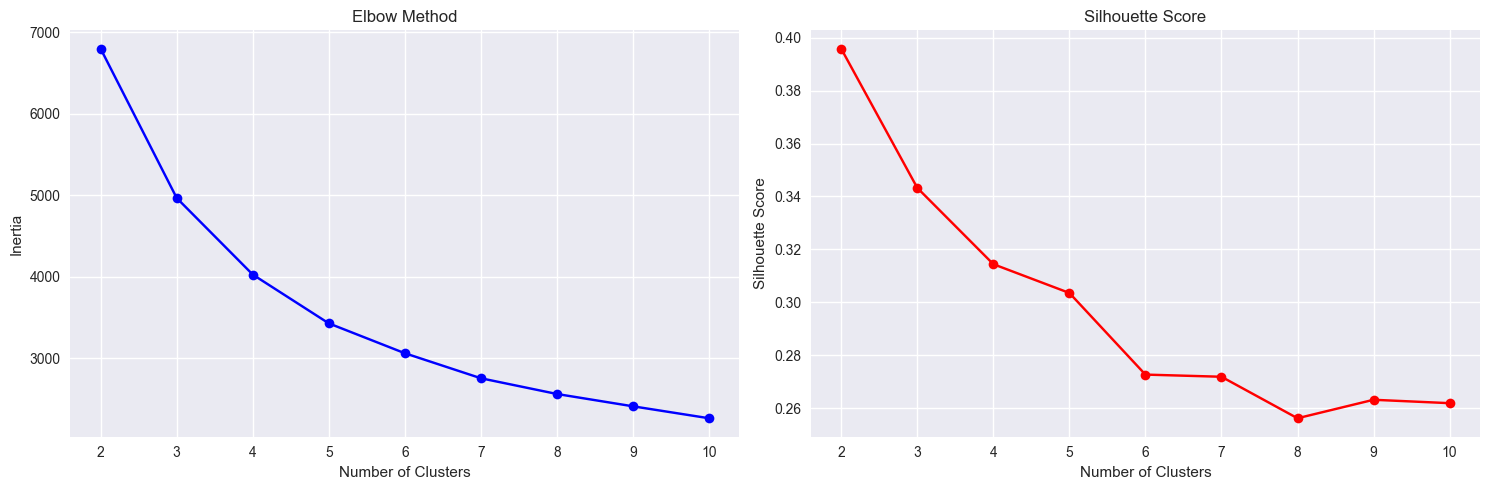

Optimal number of clusters: 2
Silhouette Score for k=2: 0.3958
Cluster Analysis:
            Recency   Frequency     Monetary  Count
Cluster                                            
0         34.228306  162.191647  3693.617407   2155
1        150.096656   22.153459   435.942461   2183


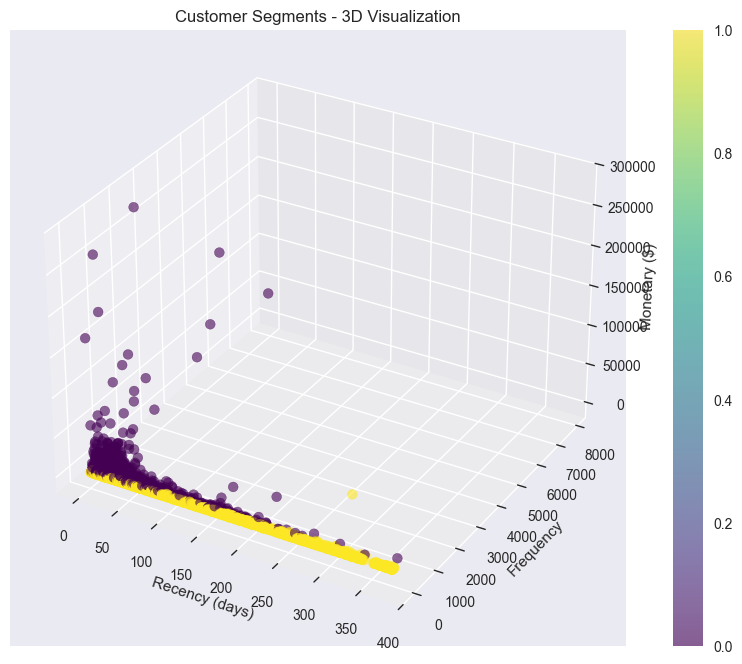


Building Product Recommendation System...
Customer-Product Matrix shape: (4338, 3665)

Recommendations for product 85123A:
  21175: 0.7497
  21733: 0.6587
  82552: 0.6439
  82551: 0.6425
  23288: 0.6310

Saving models...
Analysis complete! Models saved for Streamlit deployment.


In [9]:
# MAIN EXECUTION
# =============================================================================

def main():
    """
    Main function to execute the entire analysis
    """
    # Load and preprocess data
    print("Loading and preprocessing data...")
    df = load_and_preprocess_data('online_retail.csv')
    
    # RFM Analysis
    print("\nPerforming RFM Analysis...")
    rfm = calculate_rfm(df)
    rfm = handle_skewness(rfm)
    rfm_scaled, scaler = standardize_rfm(rfm)
    
    # Clustering Analysis
    print("\nPerforming Clustering Analysis...")
    optimal_k = find_optimal_clusters(rfm_scaled[['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']])
    kmeans, cluster_labels = perform_clustering(rfm_scaled[['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']], optimal_k)
    rfm, cluster_stats, cluster_names = analyze_clusters(rfm, cluster_labels)
    
    # Visualize clusters
    visualize_clusters(rfm)
    
    # Product Recommendation System
    print("\nBuilding Product Recommendation System...")
    customer_product_matrix = create_customer_product_matrix(df)
    model_knn, product_customer_matrix = calculate_item_similarity(customer_product_matrix)
    
    # Example: Get recommendations for a product
    example_product = df['StockCode'].iloc[0]
    recommendations = get_product_recommendations(example_product, model_knn, product_customer_matrix)
    print(f"\nRecommendations for product {example_product}:")
    for product, score in recommendations:
        print(f"  {product}: {score:.4f}")
    
    # Save models for Streamlit
    print("\nSaving models...")
    with open('kmeans_model.pkl', 'wb') as f:
        pickle.dump(kmeans, f)
    with open('scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)
    with open('recommendation_model.pkl', 'wb') as f:
        pickle.dump((model_knn, product_customer_matrix), f)
    with open('cluster_names.pkl', 'wb') as f:
        pickle.dump(cluster_names, f)
    
    print("Analysis complete! Models saved for Streamlit deployment.")

if __name__ == "__main__":
    main()